# NSW 2023 The Cost of Renting REPORT

The state of NSW is considered one of the [most expensive states within Australia](https://www.aihw.gov.au/reports/australias-welfare/housing-affordability#). This is mostly the case due to Sydney being one of the [most expensive cities to live in](https://www.yourinvestmentpropertymag.com.au/expert-insights/michael-yardney/world-s-most-expensive-cities-revealed-and-australia-makes-the-top-10#:~:text=Sydney%20has%20been%20ranked%20as,services%2C%20ranking%20equally%20with%20Copenhagen.). Nevertheless, NSW is made up of many Local Government Areas (LGAs) that accommodates people of different socioeconomic backgrounds and types of houses/apprtments. **Therefore, the aim of this analysis is to investigate the rental costs of each LGA within NSW**. In particular, this analysis will focus on determing factors that explain the cost of the weekly rents using Multiple Linear Model. **Moreover, K-Means Clustering will be used to identify groups based on the variables found to be statistically significant Multiple Linear Model**.

To conduct our analysis, a combination of datasets from [Australian Berue of Statistics](https://www.abs.gov.au/statistics/people/people-and-communities/socio-economic-indexes-areas-seifa-australia/2021?#data-downloads) and [NSW Department of Family and Community Services](https://www.facs.nsw.gov.au/resources/statistics/rent-and-sales/dashboard) has been used to create a single dataset called *Rent June 2023 Final*. The process of joining both sets involved the use of XLOOKUP function in Excel prior to the actual analysis. 

## Data Exploration

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline



# importing data for the analysis
data = pd.read_csv('Rent June 2023 Final.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16284 entries, 0 to 16283
Data columns (total 11 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   LGA                                           16164 non-null  object 
 1   Index of Relative Socioeconomic Disadvantage  16238 non-null  float64
 2   Index of Education and Occupation             16238 non-null  float64
 3   Postcode                                      16284 non-null  int64  
 4   Dwelling Types                                16284 non-null  object 
 5   Number of Bedrooms                            16284 non-null  object 
 6   First Quartile Weekly Rent for New Bonds
$    3966 non-null   float64
 7   Median Weekly Rent for New Bonds
$            3966 non-null   float64
 8   Third Quartile Weekly Rent for New Bonds
$    3966 non-null   float64
 9   New Bonds Lodged
No.                          2059 non-null  

,LGA,Index of Relative Socioeconomic Disadvantage,Index of Education and Occupation,Postcode,Dwelling Types,Number of Bedrooms,First Quartile Weekly Rent for New Bonds\n$,Median Weekly Rent for New Bonds\n$,Third Quartile Weekly Rent for New Bonds\n$,New Bonds Lodged\nNo.,Total Bonds Held\nNo.
0,Sydney,973.065405,1142.271453,2000,Total,Total,617.0,770.0,1050.0,1656.0,11203.0
1,Sydney,973.065405,1142.271453,2000,Total,Bedsitter,528.0,610.0,676.0,58.0,437.0
2,Sydney,973.065405,1142.271453,2000,Total,1 Bedroom,559.0,680.0,800.0,1052.0,5476.0
3,Sydney,973.065405,1142.271453,2000,Total,Not Specified,619.0,669.0,945.0,NaN,460.0
4,Sydney,973.065405,1142.271453,2000,Total,2 Bedrooms,1000.0,1150.0,1300.0,444.0,4110.0


In [2]:
# Data length before data cleaning

print("Length of the data before cleaning:", len(data))

Length of the data before cleaning: 16284


In [3]:
# Number of unique values/levels within each variable

data.nunique()

LGA                                              118
Index of Relative Socioeconomic Disadvantage     610
Index of Education and Occupation                610
Postcode                                         619
Dwelling Types                                     5
Number of Bedrooms                                 7
First Quartile Weekly Rent for New Bonds\n$      568
Median Weekly Rent for New Bonds\n$              373
Third Quartile Weekly Rent for New Bonds\n$      647
New Bonds Lodged\nNo.                            380
Total Bonds Held\nNo.                           1559
dtype: int64

### Discussion of the Data

The data presented by *Rent June 2023 Final* dataset contains 11 variables. Most variables within this dataset are numeric with an exception of *Number of Bedrooms, Dwelling Types and LGA*, all of which are categorical. Although variable *Postcode* may also be considered a categorical variable, however, for the purposes of this analysis, this variable will be considered numeric. The primary reason is the fact that the last three digest of the postcode indicate the [distance of the given loaction from the state's capital city in an ascending order](https://addressfinder.com.au/postcode-finder/#:~:text=Australian%20postcodes%20consist%20of%20four,the%20region%20within%20that%20state.). Hence, the last three digits (which represent this distance) will be used as the means of determining the distance away from the Sydney region. 

Furthermore, variables such as *Index of Relative Socioeconomic Disadvantage* and *Index of Education and Occupation* represent the level of Socioeconomic Disadvantage and Education/Occupation respectively. The higher the index, the better socioeconomic and educational/occupational level is within the specified area. 

## Data Cleaning

In [4]:
# Identifying the number of NULL values within each variable

data.isnull().sum()

LGA                                               120
Index of Relative Socioeconomic Disadvantage       46
Index of Education and Occupation                  46
Postcode                                            0
Dwelling Types                                      0
Number of Bedrooms                                  0
First Quartile Weekly Rent for New Bonds\n$     12318
Median Weekly Rent for New Bonds\n$             12318
Third Quartile Weekly Rent for New Bonds\n$     12318
New Bonds Lodged\nNo.                           14225
Total Bonds Held\nNo.                            8726
dtype: int64

In [5]:
# Removing all NULL values

cleanData = data.dropna()
print("The length of the data after cleaning:", len(cleanData))

The length of the data after cleaning: 2059


In [6]:
# Overview of each variable of the clean_data

cleanData.info()
len(cleanData['Postcode'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 16258
Data columns (total 11 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   LGA                                           2059 non-null   object 
 1   Index of Relative Socioeconomic Disadvantage  2059 non-null   float64
 2   Index of Education and Occupation             2059 non-null   float64
 3   Postcode                                      2059 non-null   int64  
 4   Dwelling Types                                2059 non-null   object 
 5   Number of Bedrooms                            2059 non-null   object 
 6   First Quartile Weekly Rent for New Bonds
$    2059 non-null   float64
 7   Median Weekly Rent for New Bonds
$            2059 non-null   float64
 8   Third Quartile Weekly Rent for New Bonds
$    2059 non-null   float64
 9   New Bonds Lodged
No.                          2059 non-null   

2059

In [7]:
# Create new variable Distance using postcode and inserting it into existing dataframe

data_dist = []

for i in cleanData.Postcode:
    data_dist.append(i - 2000)
    
new_data = cleanData

new_data.insert(2, 'Distance', data_dist, False)

In [8]:
# Check the outcome of the inserted coloumn

new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 16258
Data columns (total 12 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   LGA                                           2059 non-null   object 
 1   Index of Relative Socioeconomic Disadvantage  2059 non-null   float64
 2   Distance                                      2059 non-null   int64  
 3   Index of Education and Occupation             2059 non-null   float64
 4   Postcode                                      2059 non-null   int64  
 5   Dwelling Types                                2059 non-null   object 
 6   Number of Bedrooms                            2059 non-null   object 
 7   First Quartile Weekly Rent for New Bonds
$    2059 non-null   float64
 8   Median Weekly Rent for New Bonds
$            2059 non-null   float64
 9   Third Quartile Weekly Rent for New Bonds
$    2059 non-null   

In [9]:
# Overview of the data

new_data

,LGA,Index of Relative Socioeconomic Disadvantage,Distance,Index of Education and Occupation,Postcode,Dwelling Types,Number of Bedrooms,First Quartile Weekly Rent for New Bonds\n$,Median Weekly Rent for New Bonds\n$,Third Quartile Weekly Rent for New Bonds\n$,New Bonds Lodged\nNo.,Total Bonds Held\nNo.
0,Sydney,973.065405,0,1142.271453,2000,Total,Total,617.0,770.0,1050.0,1656.0,11203.0
1,Sydney,973.065405,0,1142.271453,2000,Total,Bedsitter,528.0,610.0,676.0,58.0,437.0
2,Sydney,973.065405,0,1142.271453,2000,Total,1 Bedroom,559.0,680.0,800.0,1052.0,5476.0
4,Sydney,973.065405,0,1142.271453,2000,Total,2 Bedrooms,1000.0,1150.0,1300.0,444.0,4110.0
5,Sydney,973.065405,0,1142.271453,2000,Total,3 Bedrooms,1425.0,1695.0,2050.0,79.0,665.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16246,Bourke,916.878606,880,891.280252,2880,Total,Total,260.0,300.0,380.0,129.0,1701.0
16250,Bourke,916.878606,880,891.280252,2880,Total,2 Bedrooms,245.0,280.0,300.0,31.0,532.0
16251,Bourke,916.878606,880,891.280252,2880,Total,3 Bedrooms,273.0,320.0,380.0,61.0,742.0
16253,Bourke,916.878606,880,891.280252,2880,House,Total,273.0,320.0,380.0,93.0,1259.0


### Discussion of the Data Cleaning Process

The data was cleaned from all NULL values within the dataset. Furthermore, the *Distance* variable was added into the cleaned data creating the a *new_data* dataframe. The following dataframe will be used to analyse data.

# Analysis of the Data

## Multiple Linear Regeression Analysis

This report will use Multiple Linear Regression to determine the variables that will be used for the clustering analysis. Such selection process will allow the investigation of all variables within the dataset, while pointing out those that have the most significance with rental cost. Statistically significant variables are more likely to create different groups within clustering analysis and will allow us to further investigate the difference in rental costs in the final steps of this report.

In [10]:
# Converting object into digit features and adding them into the dataframe

ord_enc = OrdinalEncoder()
new_data["dwellType_dum"] = ord_enc.fit_transform(new_data[["Dwelling Types"]]).astype('int64')
new_data["bedNum_dum"] = ord_enc.fit_transform(new_data[["Number of Bedrooms"]]).astype('int64')

new_data.info()
new_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 16258
Data columns (total 14 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   LGA                                           2059 non-null   object 
 1   Index of Relative Socioeconomic Disadvantage  2059 non-null   float64
 2   Distance                                      2059 non-null   int64  
 3   Index of Education and Occupation             2059 non-null   float64
 4   Postcode                                      2059 non-null   int64  
 5   Dwelling Types                                2059 non-null   object 
 6   Number of Bedrooms                            2059 non-null   object 
 7   First Quartile Weekly Rent for New Bonds
$    2059 non-null   float64
 8   Median Weekly Rent for New Bonds
$            2059 non-null   float64
 9   Third Quartile Weekly Rent for New Bonds
$    2059 non-null   

/var/folders/q1/0132vzfj7qd_h31gth83ggk80000gn/T/ipykernel_39732/3483471676.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data["dwellType_dum"] = ord_enc.fit_transform(new_data[["Dwelling Types"]]).astype('int64')
/var/folders/q1/0132vzfj7qd_h31gth83ggk80000gn/T/ipykernel_39732/3483471676.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data["bedNum_dum"] = ord_enc.fit_transform(new_data[["Number of Bedrooms"]]).astype('int64')


,LGA,Index of Relative Socioeconomic Disadvantage,Distance,Index of Education and Occupation,Postcode,Dwelling Types,Number of Bedrooms,First Quartile Weekly Rent for New Bonds\n$,Median Weekly Rent for New Bonds\n$,Third Quartile Weekly Rent for New Bonds\n$,New Bonds Lodged\nNo.,Total Bonds Held\nNo.,dwellType_dum,bedNum_dum
0,Sydney,973.065405,0,1142.271453,2000,Total,Total,617.0,770.0,1050.0,1656.0,11203.0,3,6
1,Sydney,973.065405,0,1142.271453,2000,Total,Bedsitter,528.0,610.0,676.0,58.0,437.0,3,4
2,Sydney,973.065405,0,1142.271453,2000,Total,1 Bedroom,559.0,680.0,800.0,1052.0,5476.0,3,0
4,Sydney,973.065405,0,1142.271453,2000,Total,2 Bedrooms,1000.0,1150.0,1300.0,444.0,4110.0,3,1
5,Sydney,973.065405,0,1142.271453,2000,Total,3 Bedrooms,1425.0,1695.0,2050.0,79.0,665.0,3,2


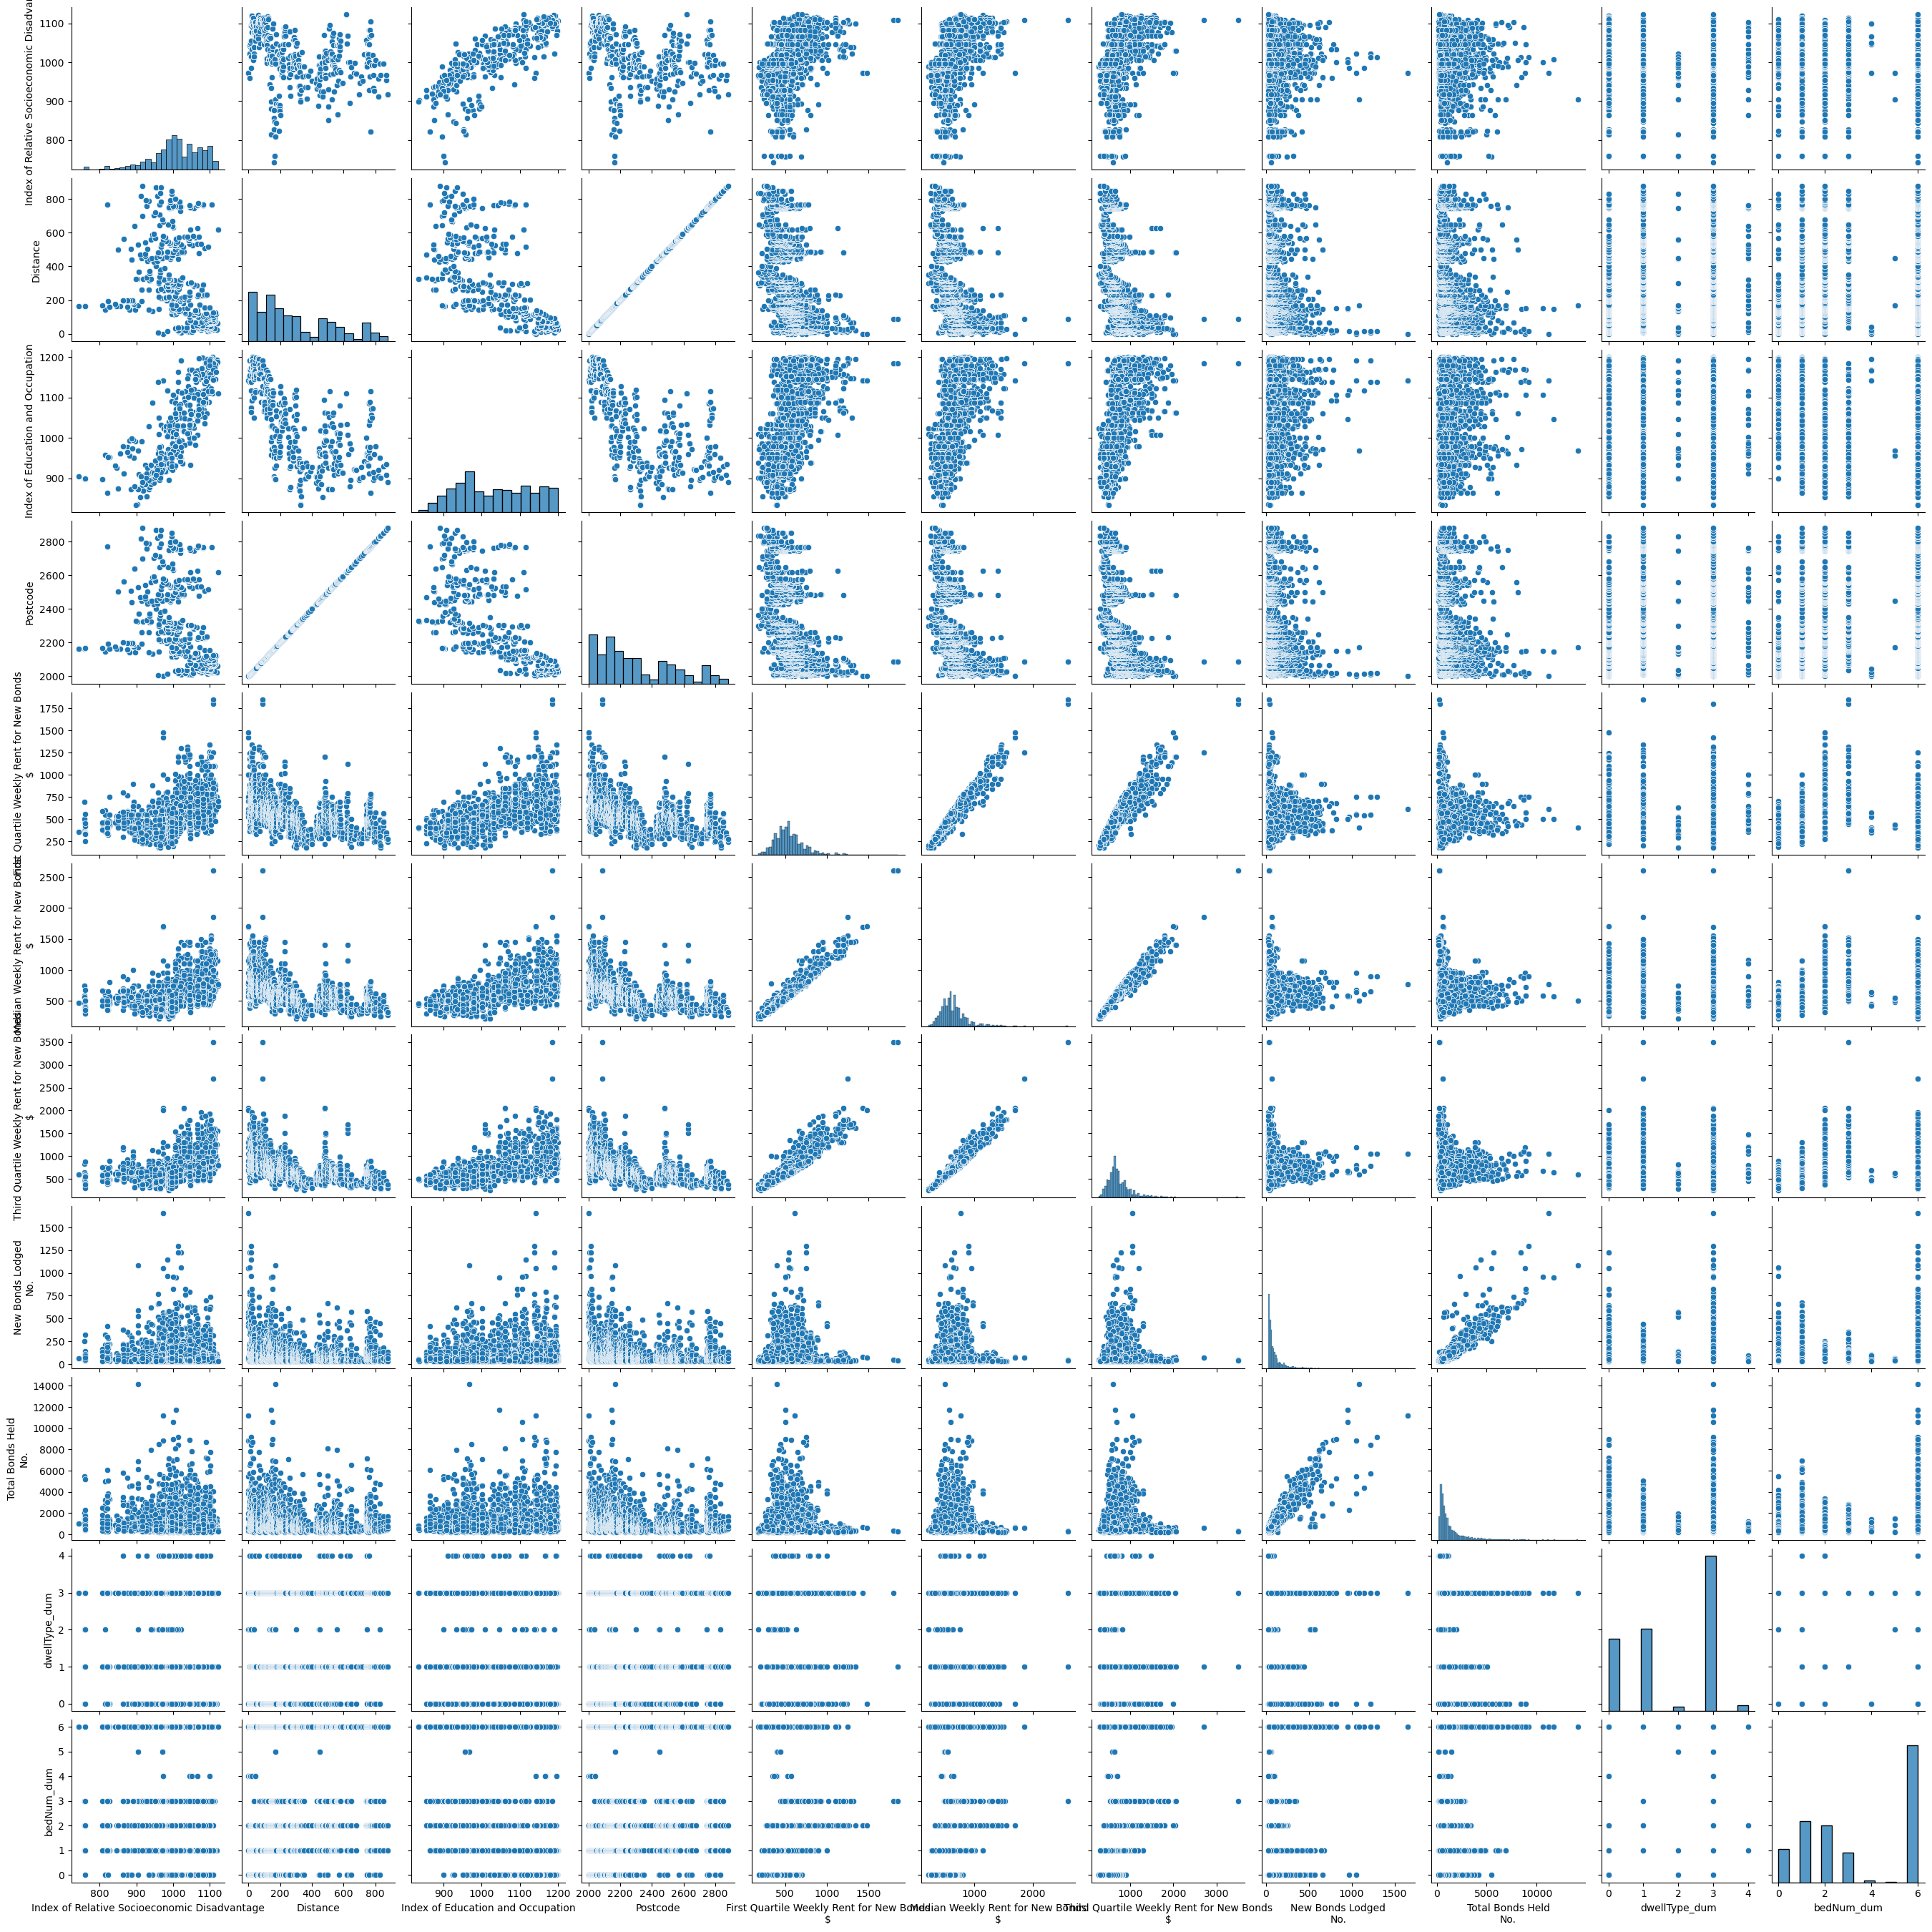

In [11]:
# Correlation Matrix - checking for multicollinearity of each variable

sns.pairplot(new_data)

In [12]:
# Multiple Linear Regression Model using all relevant variables to determine rental cost

reg = linear_model.LinearRegression()

X = new_data[['Distance','Index of Education and Occupation',
              'Index of Relative Socioeconomic Disadvantage', 'dwellType_dum', 'bedNum_dum']]
y = new_data['Median Weekly Rent for New Bonds\n$']

reg.fit(X, y)
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [-0.1718115   0.89995929  0.38296982 10.70475996 10.49938641] + -682.4696139701707


In [13]:
# Checking the Accuracy of the model

predicted = reg.predict(X)

mse = ((np.array(y)-predicted)**2).sum()/len(y)
r2 = r2_score(y, predicted)

print("MSE:", mse)
print("R Squared:", r2)

MSE: 30112.636088093335
R Squared: 0.374504106236497


The above model includes all relevant variables and explains 37.5% of variance in rental cost. However, this model can be improved by using less independent variables. In particular, there is a potential multicollinearity problem between *Index of Education and Occupation* and *Index of Relative Socioeconomic Disadvantage* variables. Hence, only one of these variables will be used depedning on the outcome of the accuracy model assessment. 

In [14]:
# Multiple Linear Regression Model using Distance and Index of Education and Occupation variables

reg = linear_model.LinearRegression()

X = new_data[['Distance','Index of Education and Occupation']]
y = new_data['Median Weekly Rent for New Bonds\n$']

reg.fit(X, y)
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [-0.11831901  1.16030809] + -526.2512390596596


In [15]:
# Accuracy of the model including Distance and Index of Education and Occupation variables only

predicted = reg.predict(X)

mse = ((np.array(y)-predicted)**2).sum()/len(y)
r2 = r2_score(y, predicted)

print("MSE:", mse)
print("R Squared:", r2)

MSE: 31184.092354799828
R Squared: 0.35224795127180164


The final model includes two independent variables *Distance* and *Index of Education and Occupation* and accounts for 35.2% of variation wihtin rental cost. Despite lower R-squared value (by 2%) and poorer MSE performace (an increase of 1072), this model includes less independent variables, while maintaining similar accuracy perfomance. Hence, *Distance* and *Index of Education and Occupation* variables will be used to conduct K-Means clustering analysis to determine different groups.

## K-Means Clustering Analysis

Before conducting the main clustering analysis, dedogram will be used to determine the optimal number of clusters. 

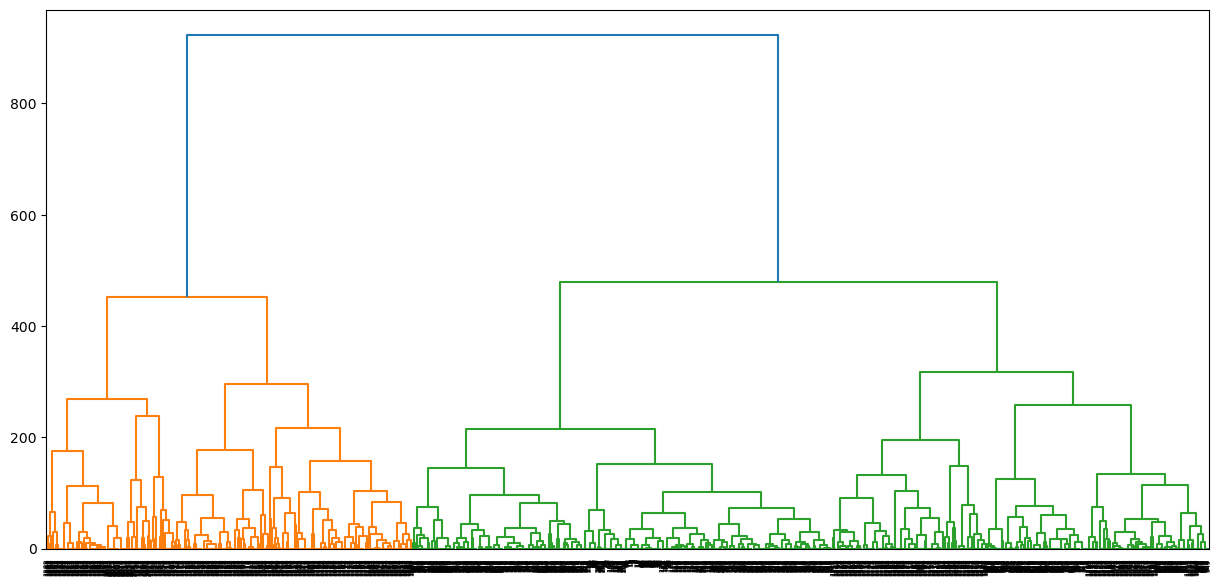

In [16]:
# Check for the optimal number of clusters using dendrogram

clustering_set = new_data.drop(columns = {"LGA", "Index of Relative Socioeconomic Disadvantage","Dwelling Types", 
                                           "Postcode", "Number of Bedrooms", 
                                      "First Quartile Weekly Rent for New Bonds\n$", 
                                      "Third Quartile Weekly Rent for New Bonds\n$", 
                                      "New Bonds Lodged\nNo.", "Total Bonds Held\nNo.",
                                         "Median Weekly Rent for New Bonds\n$", "dwellType_dum", "bedNum_dum"})



dist = pdist(clustering_set, 'euclidean')
linkage_matrix = linkage(dist, method = 'complete')
linkage_matrix

plt.figure(figsize = (15,7))
dendrogram(linkage_matrix)
plt.show()

In [17]:
# Overview of the clustering_set

clustering_set

,Distance,Index of Education and Occupation
0,0,1142.271453
1,0,1142.271453
2,0,1142.271453
4,0,1142.271453
5,0,1142.271453
...,...,...
16246,880,891.280252
16250,880,891.280252
16251,880,891.280252
16253,880,891.280252


The dedogram suggests that there are two potential clusters that exist within the dataset. Hence, K-means clustering analysis will use 2 clusters to create a model. 

/Users/olegbaronov/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='label'>

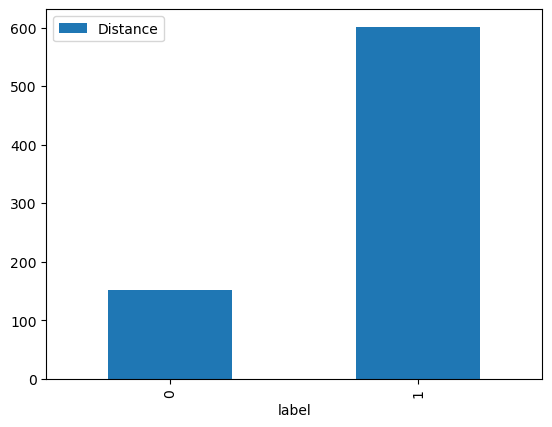

In [18]:
# K-Means Clustering Analysis

km = KMeans(n_clusters=2)
km.fit(clustering_set)

clustering_set['label'] = km.predict(clustering_set)

clustering_set_mean = clustering_set.groupby('label').agg('mean')

clustering_set_mean.plot.bar(y = "Distance")

In [19]:
# K-Means Clustering Model output

clustering_set_mean

,Distance,Index of Education and Occupation
label,,
0,151.666907,1068.855987
1,601.254464,962.973634


## Discussion of the Clustering Analysis Results

The outcome of the 2 cluster model suggests that there are 2 groups of locations that have significantly different values for distance and index of education/occupation. The group with a label 0 is mostly located further away fromt the capital city and has lower educational/occupational index, while the second group is mostly around the capital city and has higher educational/occupational index. 

# Report Discussion

The resulting clusters present differing values in term of locational and educational/occupational index. The next step is to identify the differences between both groups using other existing variables.

In [20]:
# Inserting relevant variables into existing clustering dataframe

cluster_analysis = clustering_set.join(new_data[{"Postcode", "LGA", "Index of Relative Socioeconomic Disadvantage",
                                  "Dwelling Types", "Number of Bedrooms", "Median Weekly Rent for New Bonds\n$"}])

cluster_analysis

/var/folders/q1/0132vzfj7qd_h31gth83ggk80000gn/T/ipykernel_39732/3544682344.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cluster_analysis = clustering_set.join(new_data[{"Postcode", "LGA", "Index of Relative Socioeconomic Disadvantage",


,Distance,Index of Education and Occupation,label,Number of Bedrooms,Index of Relative Socioeconomic Disadvantage,Median Weekly Rent for New Bonds\n$,LGA,Dwelling Types,Postcode
0,0,1142.271453,0,Total,973.065405,770.0,Sydney,Total,2000
1,0,1142.271453,0,Bedsitter,973.065405,610.0,Sydney,Total,2000
2,0,1142.271453,0,1 Bedroom,973.065405,680.0,Sydney,Total,2000
4,0,1142.271453,0,2 Bedrooms,973.065405,1150.0,Sydney,Total,2000
5,0,1142.271453,0,3 Bedrooms,973.065405,1695.0,Sydney,Total,2000
...,...,...,...,...,...,...,...,...,...
16246,880,891.280252,1,Total,916.878606,300.0,Bourke,Total,2880
16250,880,891.280252,1,2 Bedrooms,916.878606,280.0,Bourke,Total,2880
16251,880,891.280252,1,3 Bedrooms,916.878606,320.0,Bourke,Total,2880
16253,880,891.280252,1,Total,916.878606,320.0,Bourke,House,2880


<Axes: xlabel='Distance', ylabel='Index of Education and Occupation'>

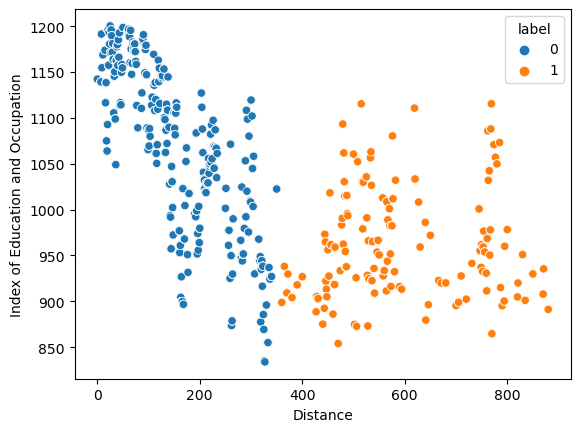

In [21]:
# Scatter plot of educational/occupational index over distance

sns.scatterplot(data = cluster_analysis, x = 'Distance', y= 'Index of Education and Occupation', hue="label")

The scatterplot presented above displays a clear difference between both groups. As the disstance increases, the group 0 (high distance; low education/occupation) overtakes, while most of the group 1 (low distance; high education) is clustered close to the beginning of the scatterplot. This plot once more visually reiterates the differences between both groups. 

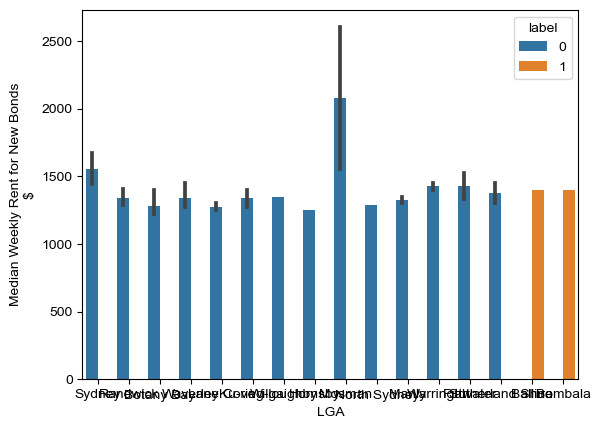

In [22]:
# Median Weekly Rent above $1200 a week by LGA 

a = cluster_analysis['Median Weekly Rent for New Bonds\n$'].where(cluster_analysis['Median Weekly Rent for New Bonds\n$']> 1200)
b = cluster_analysis['LGA'].where(cluster_analysis['Median Weekly Rent for New Bonds\n$'] > 1200)

sns.barplot(data = cluster_analysis, x = b, y= a, hue="label")
sns.set(rc = {'figure.figsize':(30, 10)})

The graph presented above display LGAs with a weekly rent over $1200 a week and while grouped by clusters. Low distance and high educational/occupational group accounts for the majority of LGAs, except Ballina and Bombala LGAs taht are located further away from the capital city. This can be explained by the fact that both of these locations are close to the boarders of the near by states of Victoria and Queensland, hence both of these location may have a high trafic of people and, therefore, higher population. However, further analysis is needed to confirm this infomation. 

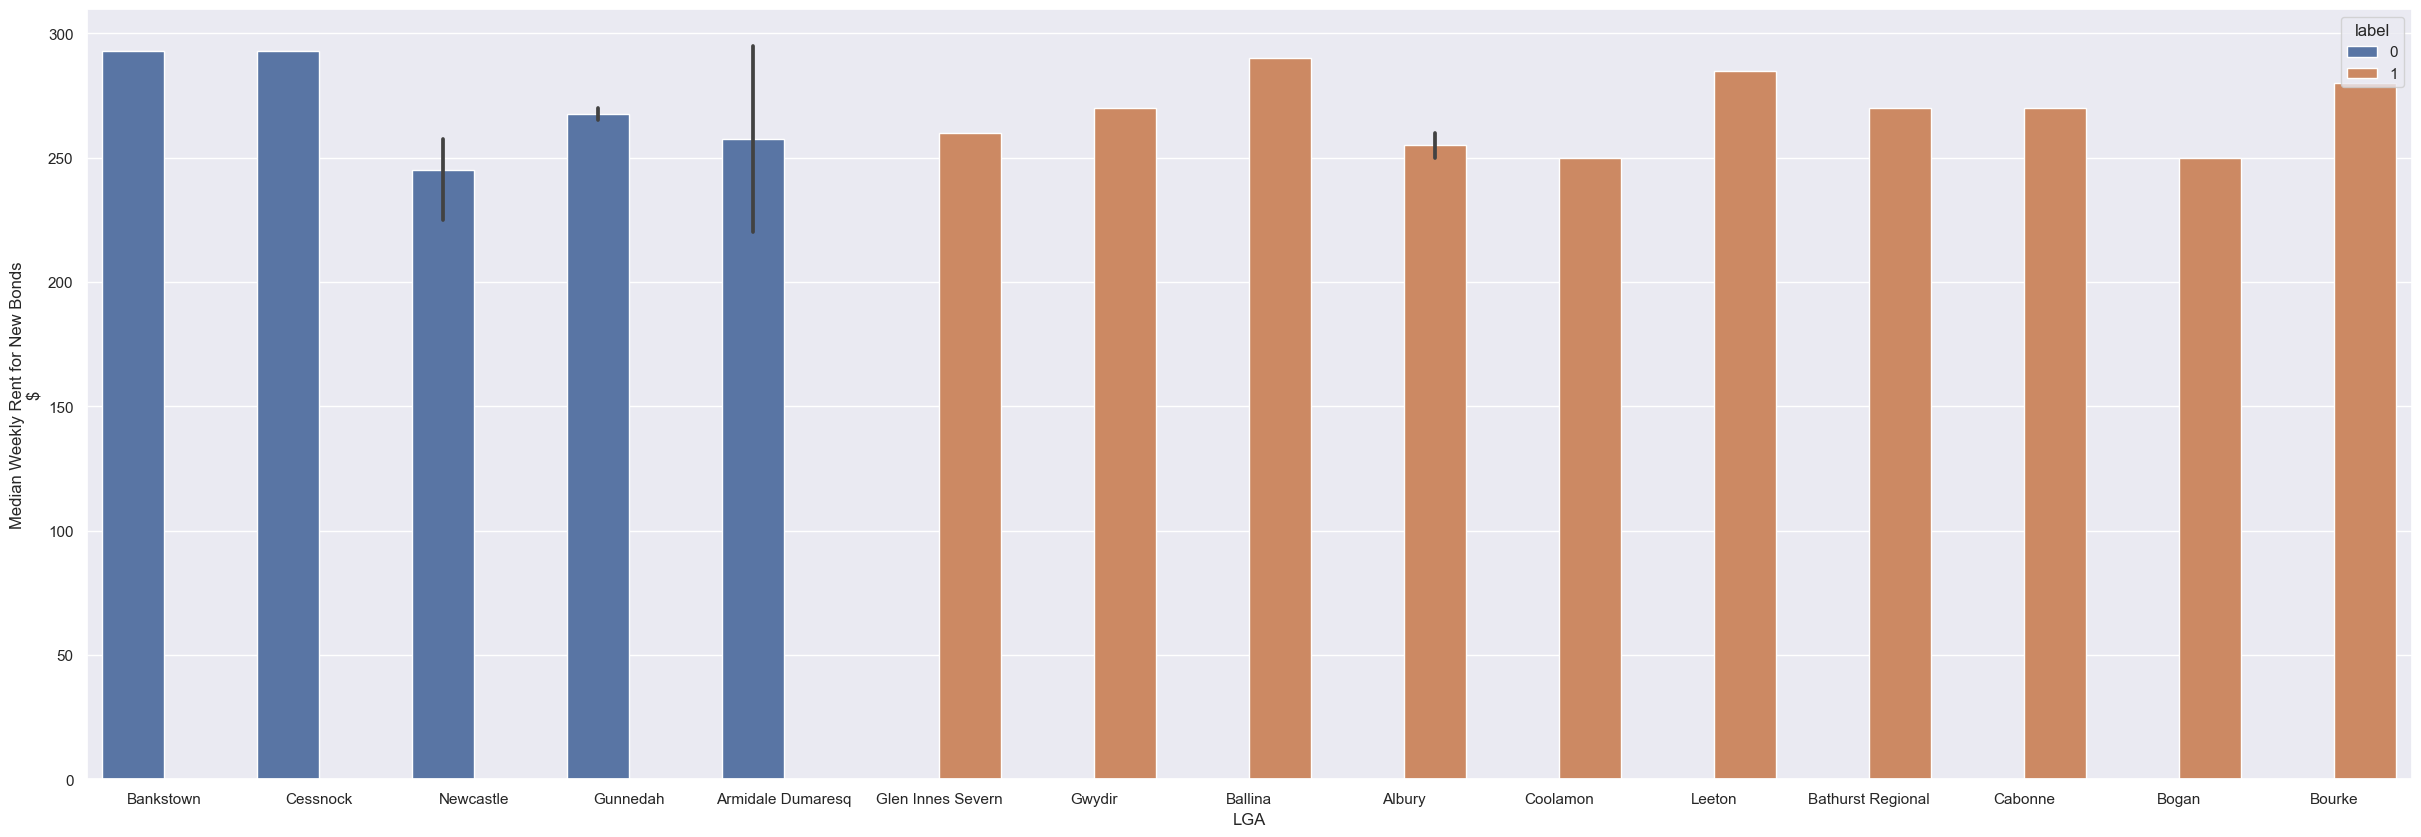

In [23]:
a = cluster_analysis['Median Weekly Rent for New Bonds\n$'].where(cluster_analysis['Median Weekly Rent for New Bonds\n$']< 300)
b = cluster_analysis['LGA'].where(cluster_analysis['Median Weekly Rent for New Bonds\n$'] < 300)

sns.barplot(data = cluster_analysis, x = b, y= a, hue="label")
sns.set(rc = {'figure.figsize':(30, 10)})

On the other side of the spectrum, LGAs with weekly rental cost lower than $300 per week is demostrated above.

As a conclusion, two main clusters of locations within the state of NSW were found. These include Low distance - High educational/occupational level and High distance - low educational/occupational level groups. Low distance - High educational/occupational level group generally pays more rent per week. However, some LGAs that are associated with High distance - low educational/occupational level group also have high rental cost, which could be attributed to the fact that these LGAs are close to the state's boarders. Nevertheless, more analysis is required to confirm this information.